In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance
import riskfolio as rp
from prophet import Prophet
from typing import List
from functions import *

In [8]:
stocks: List[str] = ["AAPL","MSFT","GOOG","IBM","GME","BP"] # List of stocks in the desired portfolio
historical_period: str = "5y" # Period to look back in the history of prices. Can be set like 1m, 3m for months; 1y,3y for years or max for all available. Default = 5y
future_period: int = 365 # Forecasting period in days. Keep in mind longer the period less accurate the results
current_dictionary = {}
future_dictionary = {}

In [9]:
for stock in stocks:
    current_dictionary[stock] = get_current_prices(stock,historical_period)
    future_dictionary[stock] = get_future_prices(current_dictionary[stock],future_period)
    
    

[*********************100%***********************]  1 of 1 completed

16:08:04 - cmdstanpy - INFO - Chain [1] start processing


16:08:04 - cmdstanpy - INFO - Chain [1] done processing


[*********************100%***********************]  1 of 1 completed

16:08:05 - cmdstanpy - INFO - Chain [1] start processing


16:08:05 - cmdstanpy - INFO - Chain [1] done processing


[*********************100%***********************]  1 of 1 completed

16:08:07 - cmdstanpy - INFO - Chain [1] start processing


16:08:07 - cmdstanpy - INFO - Chain [1] done processing


[*********************100%***********************]  1 of 1 completed

16:08:08 - cmdstanpy - INFO - Chain [1] start processing


16:08:08 - cmdstanpy - INFO - Chain [1] done processing


[*********************100%***********************]  1 of 1 completed

16:08:09 - cmdstanpy - INFO - Chain [1] start processing


16:08:10 - cmdstanpy - INFO - Chain [1] done processing


[*********************100%***********************]  1 of 1 completed

16:08:11 - cmdstanpy - INFO - Chain [1] start processing


16:08:11 - cmdstanpy - INFO - Chain [1] done processing


                AAPL      MSFT      GOOG       IBM       GME        BP
ds                                                                    
2018-01-09 -0.000115 -0.000680 -0.000614  0.002203  0.016641 -0.004875
2018-01-10 -0.000229 -0.004534 -0.003299  0.002136  0.006650  0.000700
2018-01-11  0.005680  0.002961  0.002639  0.000122  0.014227  0.008625
2018-01-12  0.010327  0.017257  0.015142 -0.006456 -0.110220  0.014791
2018-01-16 -0.005082 -0.013951 -0.000445  0.004352 -0.033784 -0.033022
...              ...       ...       ...       ...       ...       ...
2022-12-30  0.002469 -0.004938 -0.002473 -0.001205  0.007092  0.006628
2023-01-03 -0.037405 -0.001001  0.010932  0.004685 -0.068256 -0.017464
2023-01-04  0.010314 -0.043743 -0.011037  0.007418  0.006977 -0.015734
2023-01-05 -0.010605 -0.029638 -0.021869 -0.010449 -0.063510  0.003552
2023-01-06  0.013358 -0.007984 -0.002132  0.009567 -0.023428  0.013127

[1258 rows x 6 columns]


c:\Users\sedat\anaconda3\envs\finpred\lib\site-packages\riskfolio\src\PlotFunctions.py:605: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


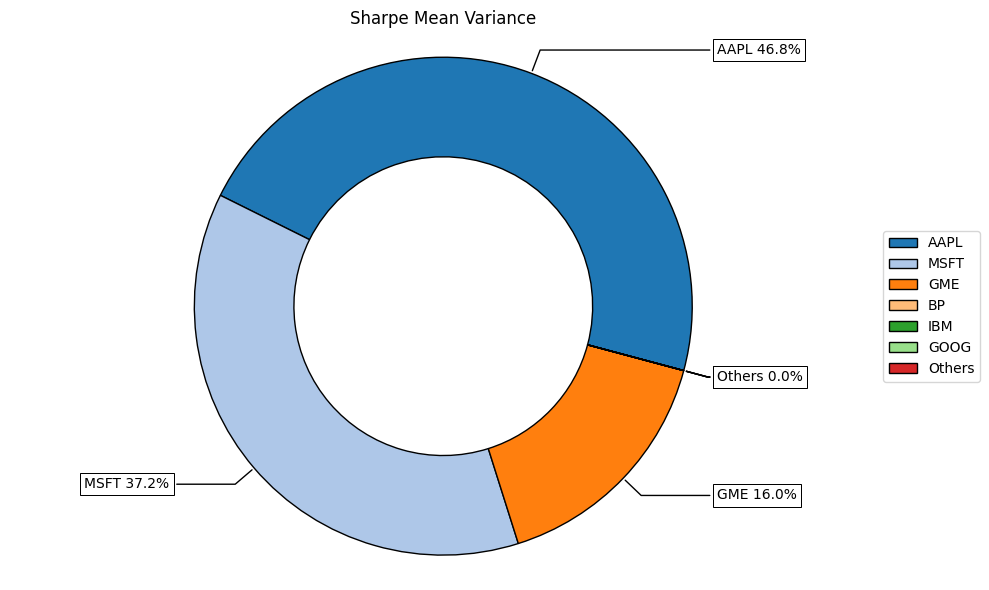

In [10]:
current_portfolio = pd.DataFrame()
for i,stock in enumerate(stocks):
    if i == 0:
        data = pd.DataFrame.from_dict(current_dictionary[stock])
        data = data.rename(columns={"y":f"{stock}"})
        current_portfolio = pd.concat([current_portfolio,data],axis=1)       
    else:
        data = pd.DataFrame.from_dict(current_dictionary[stock])
        data = data.drop("ds",axis=1,errors="ignore")
        data = data.rename(columns={"y":f"{stock}"})
        current_portfolio = pd.concat([current_portfolio,data],axis=1)
current_portfolio = current_portfolio.set_index('ds')


current_estimate = estimate_portfolio(current_portfolio)
current_plot = plot_portfolio(current_estimate)

                AAPL      MSFT      GOOG       IBM        GME        BP
ds                                                                     
2018-01-09  0.002675 -0.006336  0.000273  0.002154  -0.837411  0.008144
2018-01-10  0.002301 -0.001930  0.003546  0.000848 -12.761448  0.004482
2018-01-11 -0.002846 -0.007291  0.000376 -0.000533  -0.168821  0.002120
2018-01-12 -0.001956 -0.004400 -0.000529  0.000100   1.249901  0.002956
2018-01-16  0.015281 -0.015735  0.001383  0.004413   1.739883  0.014683
...              ...       ...       ...       ...        ...       ...
2024-01-02 -0.000200 -0.005768 -0.004447  0.002248  -0.102754  0.006369
2024-01-03 -0.000314 -0.003451  0.000453  0.001272   0.070255  0.003926
2024-01-04 -0.002237 -0.007333 -0.004547  0.000236  -0.288685  0.002469
2024-01-05 -0.001903 -0.006011 -0.006138  0.000753   0.067025  0.003475
2024-01-06  0.010139 -0.034377  0.013002  0.012770  -0.087138  0.037404

[1623 rows x 6 columns]


c:\Users\sedat\anaconda3\envs\finpred\lib\site-packages\riskfolio\src\PlotFunctions.py:605: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


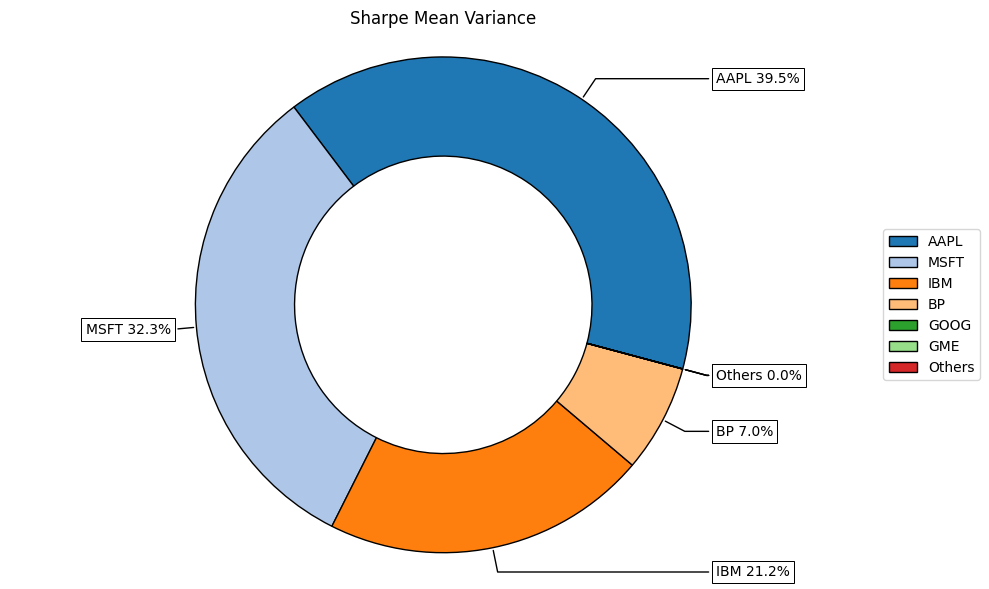

In [11]:
future_portfolio = pd.DataFrame()
for i,stock in enumerate(stocks):
    if i == 0:
        data = pd.DataFrame.from_dict(future_dictionary[stock])
        data = data.rename(columns={"yhat":f"{stock}"})
        future_portfolio = pd.concat([future_portfolio,data],axis=1)       
    else:
        data = pd.DataFrame.from_dict(future_dictionary[stock])
        data = data.drop("ds",axis=1,errors="ignore")
        data = data.rename(columns={"yhat":f"{stock}"})
        future_portfolio = pd.concat([future_portfolio,data],axis=1)
future_portfolio = future_portfolio.set_index("ds")
future_estimate = estimate_portfolio(future_portfolio)
future_plot = plot_portfolio(future_estimate)

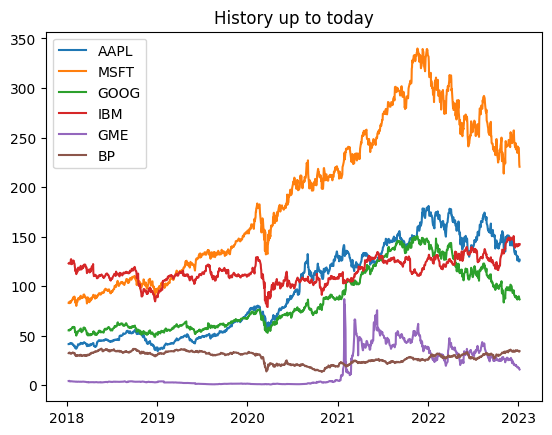

In [15]:
plt.figure()
plt.plot(current_portfolio)
plt.legend(current_portfolio.columns)
plt.title("History up to today")
plt.show()

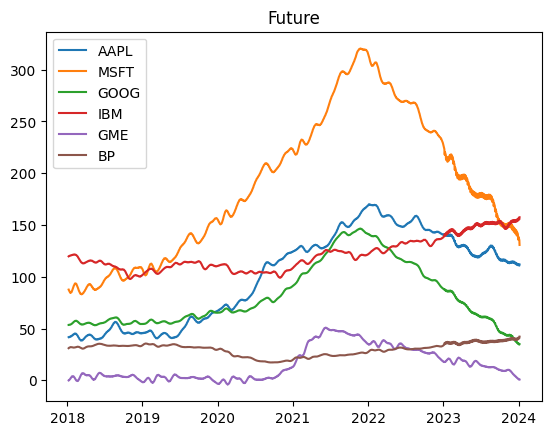

In [16]:
plt.figure()
plt.plot(future_portfolio)
plt.legend(future_portfolio.columns)
plt.title("Future")
plt.show()